<a href="https://colab.research.google.com/github/DenisB22/Mushroom-Classification-ML/blob/main/course_work_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = torch.sigmoid(self.fc3(x))
        
        return x

# Read and preprocess the data
train_data = pd.read_csv("/content/shroom/train_data.csv")
test_data = pd.read_csv("/content/shroom/test_data.csv")
train_data = train_data.drop(columns=["id"]) # Drop the ID column
test_data_ids = test_data["id"].values # Get the test data IDs
test_data = test_data.drop(columns=["id"]) # Drop the ID column

train_numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
test_numeric_features = test_data.dtypes[test_data.dtypes != 'object'].index

train_data[train_numeric_features] = train_data[train_numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

test_data[test_numeric_features] = test_data[test_numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

train_data[train_numeric_features] = train_data[train_numeric_features].fillna(0)
test_data[test_numeric_features] = test_data[test_numeric_features].fillna(0)
train_data["poisonous"] = train_data["poisonous"].apply(lambda x: 1 if x == 'y' else 0)

train_data = pd.get_dummies(train_data, dummy_na=True)
test_data = pd.get_dummies(test_data, dummy_na=True)

# print(train_data['poisonous_y'])

# le = LabelEncoder() # Encode categorical data as integers
# train_data = train_data.apply(le.fit_transform)
# # test_data = test_data.fillna(test_data.mode().iloc[0])
# test_data = test_data.apply(le.fit_transform)

X_train = train_data.drop(columns=["poisonous"]).values
y_train = train_data["poisonous"].values
X_test = test_data.values

oversample = RandomOverSampler(random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().view(-1, 1)

X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().view(-1, 1)

X_test = torch.from_numpy(X_test).float()

# Train the neural network model
net = Net()
criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_ls = []

for epoch in range(1200):
    optimizer.zero_grad()
    output = net(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_ls.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{1000}, Loss: {loss.item()}")

# Test the neural network model
with torch.no_grad():
    net.eval()
    output = net(X_val)
    predicted = (output >= 0.5).float()
    accuracy = (predicted == y_val).float().mean()
    print(f"Validation Accuracy: {accuracy.item()}")

# Generate predictions for the test data
with torch.no_grad():
    net.eval()
    output = net(X_test)
    predicted = (output >= 0.5).float().view(-1)
    predicted_labels = l.inverse_transform(predicted.int().numpy())

# Write the predicted labels to a CSV file
output_df = pd.DataFrame({"id": test_data_ids, "poisonous": predicted_labels})
output_df.to_csv("result.csv", index=False)

# Load the predicted labels from the result.csv file
df = pd.read_csv("/content/result.csv")

# Convert the numerical labels to "y" or "n"
df["poisonous"] = df["poisonous"].apply(lambda x: "y" if x == 's' else "n")

# Save the updated labels to a new file
df.to_csv("result_updated.csv", index=False)


Epoch 1/1000, Loss: 0.6937305331230164
Epoch 101/1000, Loss: 0.00019353243988007307
Epoch 201/1000, Loss: 8.46208495204337e-05
Epoch 301/1000, Loss: 4.832736885873601e-05
Epoch 401/1000, Loss: 3.1347357435151935e-05
Epoch 501/1000, Loss: 2.196307286794763e-05
Epoch 601/1000, Loss: 1.6230724213528447e-05
Epoch 701/1000, Loss: 1.2485690604080446e-05
Epoch 801/1000, Loss: 9.897690688376315e-06
Epoch 901/1000, Loss: 8.025695933611132e-06
Epoch 1001/1000, Loss: 6.6259599407203496e-06
Epoch 1101/1000, Loss: 5.557154509006068e-06
Validation Accuracy: 0.9955357313156128


NameError: ignored

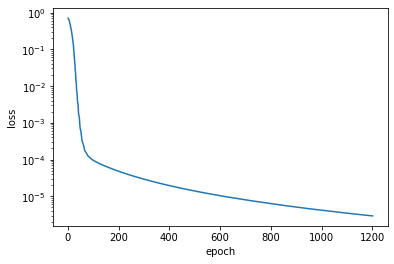

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, 1200+1), train_ls)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.show()